In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm     # pip3/pip/conda install tqdm
import os

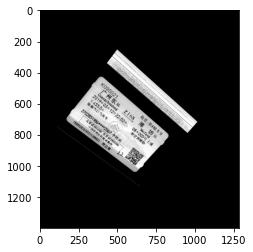

In [167]:
att_img = "train/0036.bmp"
att_img = cv2.imread(att_img, cv2.IMREAD_GRAYSCALE)
padding = 100
att_img = np.pad(att_img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))

plt.imshow(att_img, cmap='gray')

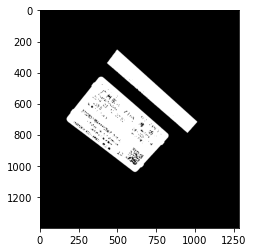

In [168]:
# 滤波前是否需要中值滤波？
blurred_img = cv2.medianBlur(att_img, 5)

_, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)
plt.imshow(thres_img, cmap='gray')

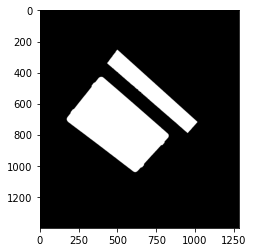

In [169]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)) # 参数是否可以自适应
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(morphed_img, cmap='gray')

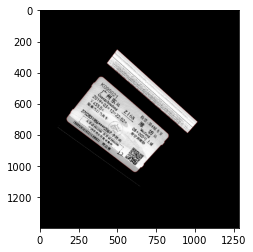

In [170]:
# https://www.jb51.net/article/164348.htm
canny = cv2.Canny(morphed_img, 40, 150)

contour_img = cv2.cvtColor(att_img, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), )

plt.imshow(contour_img)

In [171]:
def solve(p1, p2, p3, p4):
    A = np.array([[p2[1]-p1[1], p1[0]-p2[0]], [p4[1]-p3[1], p3[0]-p4[0]]])
    B1 = np.array([[(p2[1]-p1[1])*p1[0]+(p1[0]-p2[0])*p1[1], p1[0]-p2[0]], 
                  [(p4[1]-p3[1])*p3[0]+(p3[0]-p4[0])*p3[1], p3[0]-p4[0]]])
    B2 = np.array([[p2[1]-p1[1], (p2[1]-p1[1])*p1[0]+(p1[0]-p2[0])*p1[1]],
                  [p4[1]-p3[1], (p4[1]-p3[1])*p3[0]+(p3[0]-p4[0])*p3[1]]])
    A, B1, B2 = map(lambda x: np.linalg.det(x), (A, B1, B2))
    return B1/A, B2/A

def handle_not_rect(points):
    new_points = np.zeros((points.shape[0] - 1, points.shape[1]))
    dist_list = [np.linalg.norm(points[i] - points[i - 1]) for i in range(points.shape[0])]
    i = np.argmin(np.array(dist_list)) # 缩点(i-2, i-1), (i, i+1)
    x, y = solve(points[i-2], points[i-1], points[i], points[i+2])
    # print(new_points[:i-1, :].shape, points[:i-1, :].shape, i)
    if i > 0:
        new_points[:i-1, :] = points[:i-1, :]
    new_points[i-1, :] = np.array([x, y])
    new_points[i:, :] = points[i+1:, :]
    return new_points


(528, 1, 2)


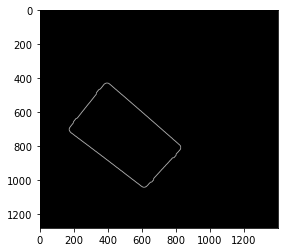

In [172]:
max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp
print(max_contour.shape)
max_contour = max_contour[::-1, :, :]

edge = np.zeros((att_img.shape[1], att_img.shape[0], 3), dtype=np.int32)
cv2.drawContours(edge, [max_contour], -1, (255, 255, 255), 2)
# edge = cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2GRAY)

plt.imshow(edge, cmap='gray')

In [173]:
def fetch_line(lines):
    cnt = 0
    fetch_lines = np.zeros((4, 2))
    for rho, theta in lines:
        for i in range(cnt):
            if abs(rho - fetch_lines[i][0]) < 50 and abs(theta - fetch_lines[i][1]) < np.pi / 180*3:
                break
        else:
            fetch_lines[cnt][0], fetch_lines[cnt][1] = rho, theta
            cnt += 1
        if cnt == 4:
            break
    return fetch_lines

In [174]:
def solve_l(rho1, theta1, rho2, theta2):
    # print(rho1, theta1, rho2, theta2)
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    B2 = np.array([[np.cos(theta1), rho1],
                   [np.cos(theta2), rho2]])
    B1 = np.array([[rho1, np.sin(theta1)],
                   [rho2, np.sin(theta2)]])
    A, B1, B2 = map(lambda x: np.linalg.det(x), (A, B1, B2))
    return B1/A, B2/A
    

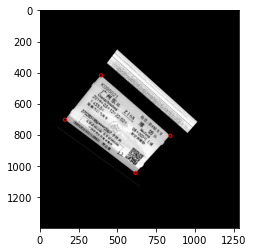

In [191]:
edge2 = cv2.cvtColor(edge.astype(np.uint8), cv2.COLOR_BGR2GRAY)
lines = cv2.HoughLines(edge2, 1, np.pi / 180, 200)
lines = lines.squeeze()
# print(lines)
fetch_lines = fetch_line(lines)
if abs(fetch_lines[0][1] - fetch_lines[1][1]) < np.pi / 180 * 25:  # 25度以内认为平行的
    fetch_lines[[1, 2], :] = fetch_lines[[2, 1], :]
elif abs(fetch_lines[2][1] - fetch_lines[1][1]) < np.pi / 180 * 25:
    fetch_lines[[0, 1], :] = fetch_lines[[1, 0], :]
# print(fetch_lines) 

points = [solve_l(*fetch_lines[i-1], *fetch_lines[i]) for i in range(4)]

pt_img = cv2.cvtColor(att_img ,cv2.COLOR_GRAY2BGR)
points = np.around(np.array(points)).astype(np.int32)

for i in range(4):
    cv2.circle(pt_img, (points[i][0], points[i][1]), 10, (255, 0, 0), 5)
plt.imshow(pt_img)


In [192]:
c = np.cross(points[1]-points[0], points[2]-points[1])
if c > 0:   # 修正为右旋标价
    points = points[::-1, :]

len1 = np.linalg.norm(points[0] - points[1])
len2 = np.linalg.norm(points[1] - points[2])
if len1 >= len2:    # 短边优先
    points = np.roll(points, 1, axis=0)

if points[0][0] > points[2][0]: # y值小的优先
    points = np.roll(points, 2, axis=0)


使用仿射变换将取出的四边形区域变换为矩形，变换矩阵的推导如下：
$$
\left[\begin{matrix}
a_{11}&a_{12}&a_{13}\\
a_{21}&a_{22}&a_{23}\\
0&0&1
\end{matrix}\right]\cdot\left[\begin{matrix}
x_i\\
y_i\\
1\\
\end{matrix}\right]=\left[\begin{matrix}
x'_i\\
y'_i\\
1\\
\end{matrix}\right]
$$
将上式做等效改写：
$$
\left[\begin{matrix}
x_i&y_i&1&0&0&0\\
0&0&0&x_i&y_i&1\\
\end{matrix}\right]\cdot\left[\begin{matrix}
a_{11}\\a_{12}\\a_{13}\\a_{21}\\a_{22}\\a_{23}
\end{matrix}\right]=\left[\begin{matrix}
x'_i\\y'_i
\end{matrix}\right]
$$
对于$n$个基准点，左侧矩阵是大小为$2n\times6$，不妨设上式对应的矩阵依次记为：
$$
M\cdot A = N
$$
此处$n=4$，采用最小二乘法：
$$A=(M^TM)^{-1}\cdot M^TN$$
由于$(M^TM)^{-1}$可能不是满秩，引入小常数$\epsilon=0.001$修正：
$$A=(M^TM+\epsilon I)^{-1}\cdot M^TN$$

In [193]:
shape_x, shape_y = int(856 / 1.5), int(540 / 1.5) # 蓝票标准长宽比

epsilon = 1e-3
outer_x, outer_y = 20, 20

M = np.zeros((8, 6))
N = np.array([outer_x, outer_y, outer_x, shape_y - outer_y, 
            shape_x - outer_x, shape_y - outer_y, shape_x - outer_x, outer_y])

for i in range(4):
    M[2*i, :] = np.array([points[i][0], points[i][1], 1, 0, 0, 0])
    M[2*i + 1, :] = np.array([0, 0, 0, points[i][0], points[i][1], 1])

A = np.linalg.inv(np.dot(M.T, M) + epsilon * np.eye(6))
A = np.dot(A, np.dot(M.T, N))
A = A.reshape((2, 3))
print(A)

[[   0.69101283    0.59742155 -505.552671  ]
 [  -0.57929688    0.71288546  -60.14400741]]


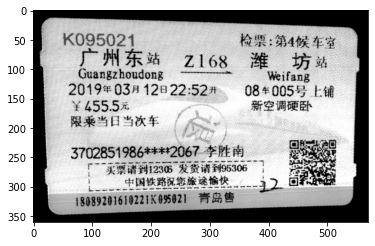

In [194]:
output1 = cv2.warpAffine(att_img, A, (shape_x, shape_y))
plt.imshow(output1, cmap='gray')

最后用霍夫变换fix一下

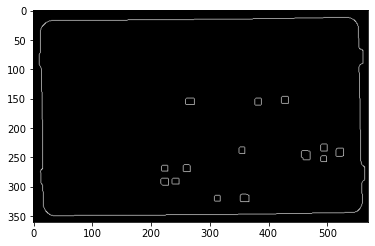

In [53]:
blurred_img = cv2.medianBlur(output1, 5)
_, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)

canny = cv2.Canny(morphed_img, 40, 150)
plt.imshow(canny, cmap='gray')

[[[  21.           1.553343 ]]

 [[ 352.           1.553343 ]]

 [[ 348.           1.5707964]]

 [[-553.           3.1241393]]

 [[ -12.           3.1241393]]

 [[  17.           1.5707964]]]


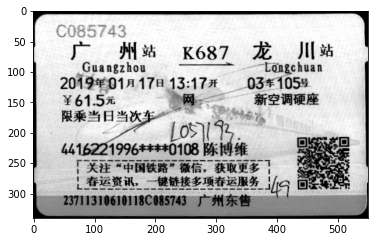

In [57]:
lines = cv2.HoughLines(canny, 1, np.pi / 180, 100)
print(lines)
lines = lines.squeeze()

angle, cnt = 0, 0
for _, theta in lines:
    theta = theta * 180 / np.pi - 90
    if np.abs(theta) < 10:
        angle = angle * cnt + theta
        cnt += 1
        angle /= cnt
mat = cv2.getRotationMatrix2D((shape_x/2, shape_y/2), angle, 1)
fixed_img = cv2.warpAffine(output1, mat, (shape_x, shape_y))

# 裁剪一下边缘
output = fixed_img[outer_y>>1:shape_y-(outer_y>>1), outer_x>>1:shape_x-(outer_x>>1)]

plt.imshow(output, cmap='gray')

以下是上述操作的汇总

In [40]:
def extract_ticket(att_img):
    padding = 100
    att_img = np.pad(att_img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))
    blurred_img = cv2.medianBlur(att_img, 5)
    _, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)

    canny = cv2.Canny(morphed_img, 40, 150)
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_contour ,max_area = 0, 0
    for contour in contours:
        tmp = cv2.contourArea(contour)
        if tmp > max_area:
            max_contour, max_area = contour, tmp

    poly_contour = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)
    points = poly_contour.squeeze()
    while points.shape[0] > 4:
        points = handle_not_rect(points)

    shape_x, shape_y = int(856 / 1.5), int(540 / 1.5) # 蓝票标准长宽比

    c = np.cross(points[1]-points[0], points[2]-points[1])
    if c > 0:   # 修正为右旋标价
        points = points[::-1, :]

    len1 = np.linalg.norm(points[0] - points[1])
    len2 = np.linalg.norm(points[1] - points[2])
    if len1 >= len2:    # 短边优先
        points = np.roll(points, 1, axis=0)

    if points[0][0] > points[2][0]: # y值小的优先
        points = np.roll(points, 2, axis=0)
    
    epsilon = 1e-3
    outer_x, outer_y = 20, 20

    M = np.zeros((8, 6))
    N = np.array([outer_x, outer_y, outer_x, shape_y - outer_y, 
                shape_x - outer_x, shape_y - outer_y, shape_x - outer_x, outer_y])

    for i in range(4):
        M[2*i, :] = np.array([points[i][0], points[i][1], 1, 0, 0, 0])
        M[2*i + 1, :] = np.array([0, 0, 0, points[i][0], points[i][1], 1])

    A = np.linalg.inv(np.dot(M.T, M) + epsilon * np.eye(6))
    A = np.dot(A, np.dot(M.T, N))
    A = A.reshape((2, 3))

    return cv2.warpAffine(att_img, A, (shape_x, shape_y))

In [66]:
def hoffle_fix(output1):
    blurred_img = cv2.medianBlur(output1, 5)
    _, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)

    canny = cv2.Canny(morphed_img, 40, 150)

    lines = cv2.HoughLines(canny, 1, np.pi / 180, 100)
    lines = lines.squeeze()

    angle, cnt = 0, 0
    for _, theta in lines:
        theta = theta * 180 / np.pi - 90
        if np.abs(theta) < 10:
            angle = angle * cnt + theta
            cnt += 1
            angle /= cnt
    mat = cv2.getRotationMatrix2D((shape_x/2, shape_y/2), angle, 1)
    fixed_img = cv2.warpAffine(output1, mat, (shape_x, shape_y))

    # 裁剪一下边缘
    return fixed_img[outer_y>>1:shape_y-(outer_y>>1), outer_x>>1:shape_x-(outer_x>>1)]

在所有训练集上跑：

In [59]:
input_path = "./train"
output_path = "./tickets"

if not os.path.exists(output_path):
    os.mkdir(output_path)

for file_name in tqdm(os.listdir(input_path)):
    try:
        img = cv2.imread(os.path.join(input_path, file_name), cv2.IMREAD_GRAYSCALE)
        ticket_img = extract_ticket(img)
        ticket_img = hoffle_fix(ticket_img)
        cv2.imwrite(os.path.join(output_path, file_name), ticket_img)
    except RuntimeError as e:
        print("\nFail at {}: {}, skipped".format(file_name, e.args[0]))
print('\ndone!')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.66it/s]
done!

